<a href="https://colab.research.google.com/github/weiweitoo/airline-twitter-sentiment/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Fellowship.ai Challenge: ULMFiT applied to the Twitter US Airline Sentiment dataset

# Abstract

# Introduction

- There are 4 challenge is elected for this challenge set. 3 of them are computer vision related. Only the last one is NLP, which is the field that i am interested in. 
- Recent trend in NLP task, it is going towards transfer-learning from those pretraining like ULMFiT, BERT, XLNet and RoBERTo. This became a very important concept in NLP field, especially for language modeling or classification task.


# Related work

Twitter US Airline Dataset is a popular dataset in Kaggle for various task such as Sentiment Analysis and Visualization. Both of the following benchmark train and evaluate under class imbalance situation(Accuracy is not precise when class is imbalance)

[Benchmark](https://www.kaggle.com/davidbankom/twitter-us-airlines-sentiment-with-ulmfit-approach): Accuracy 82.78 using ULMFiT

[Benchmark](https://www.kaggle.com/neoyipeng2018/bert-using-fastai): Accuracy 86.99 using BERT

# Model

## Setup

In [0]:
from google.colab import drive

In [0]:
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# !pip install fastai

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
root_path = "drive/My Drive/Colab Notebooks/AirlineTweetSentiment"
df = pd.read_csv(root_path + "/Tweets.csv")

## Utils

In [0]:
def plot_bar(dictionary, title):
  plt.title(title)
  bar_plot = plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
  plt.xticks(range(len(dictionary)), list(dictionary.keys()), rotation=45)
  plt.show()
  return plt, bar_plot

In [0]:
#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

def synonym_replacement(words, n):
	new_words = words
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')
 
	return ' '.join(new_words)

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
# synonym_replacement("This is a very good airline service", 2)

'T h i s   i s   a   v e r yttrium   gib o o d   a i r l i n e   s e r v i c e'

In [0]:
# def generate_sample(row, n):
#   row['text_new'] = synonym_replacement(row['text'], n)
#   return row

In [0]:
# df[df['airline_sentiment'] == "neutral"].apply(lambda row: generate_sample(row, 4), axis=1)

## Data Preparation

In [0]:
total_data_size = df.shape[0]
print(f'Total Size :{total_data_size}')

Total Size :14640


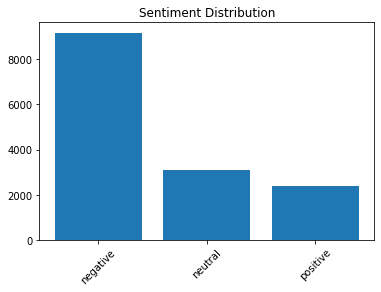

In [0]:
airline_sentiment = df['airline_sentiment'].value_counts()
plt, bar_plot = plot_bar(airline_sentiment.to_dict(), "Sentiment Distribution")

In [0]:
negative_reason = df_reason['negativereason'].value_counts().to_dict()
plot_bar(negative_reason, "Negative Reason Distribution")

NameError: ignored

In [0]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

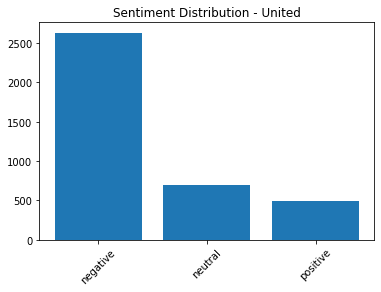

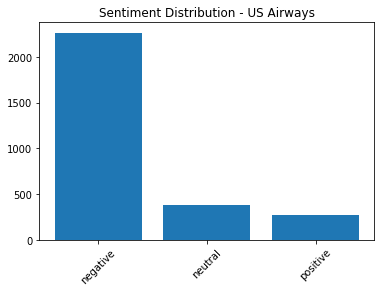

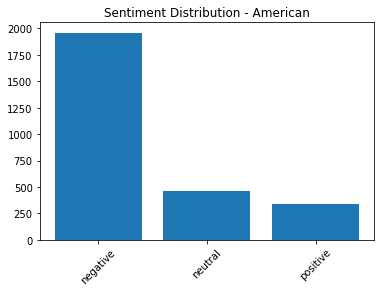

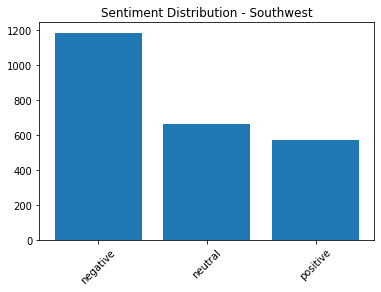

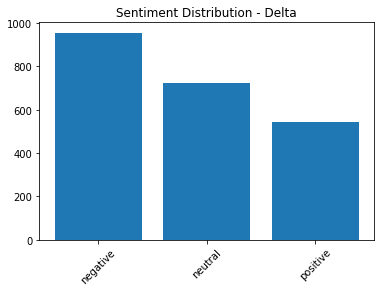

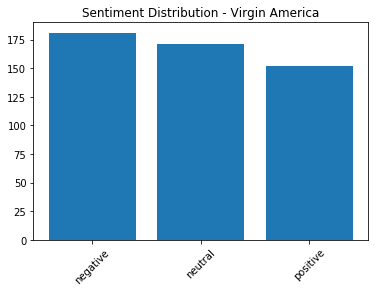

In [0]:
airlines = ['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America']
for airline in airlines:
  tmep = df[df['airline'] == airline]
  negative_reason = tmep['airline_sentiment'].value_counts().to_dict()
  plot_bar(negative_reason, f"Sentiment Distribution - {airline}")

TODO: fix class imbalance with sampling and augmentation

Perform neccsaary preprocessing step on the text data so that model can learn better
- Remove username which is do not contain important information for text classification, such as @elonmusk
- Remove website link
- Remove unessary information like $30 or 10:30
- Other basic preprocessing

Perform word tokenization, proper word tokenization rules help model learn better. 

Here is the meaning of the special tokens:
*   UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
*   PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
*   BOS (xxbos) represents the beginning of a text in your dataset
*   FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
*   TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
*   TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
*   TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
*   TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

Refer [here](https://docs.fast.ai/text.transform.html#BaseTokenizer) for more information


In [0]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # remove screen_name
  sentence = re.sub(r"(@[a-zA-Z_]{1,})", " ", sentence)
  # remove website link
  sentence = re.sub(r"((http://|https://|www\.)+.{1,})", " ", sentence)
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,/#])", r" \1 ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [0]:
preprocess_sentence("@VirginAmerica I didn't today... Must mean I need to take another trip!")

'i didn t today . . . must mean i need to take another trip !'

In [0]:
df['text'] = df['text'].apply(lambda row: preprocess_sentence(row))

## Sentiment Analysis Training

In [0]:
def construct_input(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  col_names = ['labels','text']
  df_trn = pd.DataFrame({'text':X_train, 'labels':y_train}, columns=col_names)
  df_val = pd.DataFrame({'text':X_test, 'labels':y_test}, columns=col_names)
  data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)
  data_clas = TextClasDataBunch.from_df(path = "./", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)
  data_lm.save('tmp_lm')
  data_clas.save('tmp_clas')
  return data_lm, data_clas

def learn_language_model(data_lm, lr):
  learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
  ## Train last layer
  learn.freeze_to(-1)
  learn.fit_one_cycle(1, slice(2e-3/100, lr))
  ## Train last 2 layer
  lr /= 2
  learn.freeze_to(-2)
  learn.fit_one_cycle(1, slice(2e-3/100, lr))
  ## Train remaining of the layer
  lr /= 2
  learn.unfreeze()
  learn.fit_one_cycle(2, slice(2e-3/100, lr))
  learn.save_encoder("ft_enc")
  return learn

def learn_classification_model(data_clas, lr):
  learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
  learn.load_encoder('ft_enc')
  ## Train last layer
  learn.freeze_to(-1)
  learn.fit_one_cycle(1, slice(2e-3/100, lr))
  ## Train last 2 layer
  lr /= 2
  learn.freeze_to(-2)
  learn.fit_one_cycle(1, slice(2e-3/100, lr))
  ## Train remaining of the layer
  lr /= 2
  learn.unfreeze()
  learn.fit_one_cycle(2, slice(2e-3/100, lr))
  return learn

In [0]:
X = df['text']
y = df['airline_sentiment']
data_lm, data_clas = construct_input(X, y, 0.3)

In [0]:
learner_lm = learn_language_model(data_lm, 2e-3)
learner_clas = learn_classification_model(data_clas, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.059510,5.542489,0.138984,06:35


epoch,train_loss,valid_loss,accuracy,time
0,5.250743,4.866812,0.186752,06:51


epoch,train_loss,valid_loss,accuracy,time
0,4.947210,4.664583,0.206105,09:51
1,4.830405,4.602832,0.211674,09:49


epoch,train_loss,valid_loss,accuracy,time
0,0.803987,0.623560,0.755464,04:26


epoch,train_loss,valid_loss,accuracy,time
0,0.745459,0.564914,0.780738,05:29


epoch,train_loss,valid_loss,accuracy,time
0,0.667111,0.518752,0.796220,13:18


In [0]:
import datetime
now = datetime.datetime.now().strftime("%I_%M_%b_%d_%Y")
print(now)

learner_lm.path = root_path + "/" + now + "/model_lm"
learner_lm.export('export.pkl')
learner_clas.path = root_path + "/" + now + "/model_clas"
learner_clas.export('export.pkl')

In [0]:
leaner_lm = load_learner(root_path + "/" + now + "/model_lm")
leaner_clas = load_learner(root_path + "/" + now + "/model_clas")

Train model with Gradual unfreezing
```
https://towardsdatascience.com/understanding-language-modelling-nlp-part-1-ulmfit-b557a63a672b
```

TODO: Assessment of result

TODO
```
Now that I have a model, how can I be sure that I didn't introduce a bug in the code? If results are too good to be true, they probably are!

What are some of the weaknesses of the model and and how can the model be improved with additional work?
```

# Future work

# Negative Reason Prediction

In [0]:
X = df['text']
y = df['negativereason']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
data_lm, data_clas = construct_input(X, y, 0.3)

In [0]:
learner_lm = learn_language_model(data_lm)
learner_clas = learn_classification_model(data_clas)